# **Fine-tuning a petrained Model**

un'altra tecnica molto utilizzata che prevede l'utilizzo di un modello pre-addestrato, complementare al feature extraction, è il **Fine-Tuning.** \\
Il Fine-tuning consiste nell'andare a **"scongelare" i pesi di layer che si trovano al top di una base convulazione congelata** utilizzata per fare feature extraction e successivamente allenare sia i layer scongelati e sia il nuovo classificatore aggiunto.

Quindi la **differenza tra Feature Extraction (transfer learning) e Fine-tuning** è che nel primo caso la rete pre-addestrata è completamente congelata, quindi nessun layer cambierà i propri pesi durante la fase di addestramento, mentre, nel Fine-Tuning, alcuni layer della rete pre-addestrata vengono scongelati, in modo che durante la fase di training, i pesi vengono cambiati per adattarsi al nostro task personalizzato.

**Una cosa importante è che è possibile fine-tunare i top layer di un modello pre-addestrato solo dopo che il classificatore aggiunto al top del modello (modello aggiunto da noi per il nostro task) è stato allenato.** Se il classificatore non è stato allenato, i suoi pesi verranno inizializzati inizialmente in maniera casuale, quindi la propagazione dell'errore sarà grande l'apprendimento dei layer fine-tunati verrà perso.

In [1]:
!unzip -qq train.zip

In [2]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]

    for fname in fnames:
      shutil.copyfile(src=original_dir / fname,
      dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


**I passi per Fine-tunare un modello pre-addestrato sono:**
1. **Aggiungere la nostra rete personalizzata al top** del modello pre-addestrato
2.**Freezare i pesi** del modello pre-addestrato di base
3.**Allenare la rete personalizzta** (parte aggiunta)
4. **Scongelare i pesi di alcuni layer della rete personalizzata** (NB: i layer di **batch normalization** non devono essere scongelati, in quanto non sono utili alla classificazione)
5. **Allenare la parte aggiunta e i layer scongelati.**

Con il metodo del feature extraction, si eseguono i primi 3 step, per fare fine-tuning bisogna completare anche il passo 4 e 5 che fanno riferimento allo scongelamento di alcuni layer.

**Iniziamo con l'eseguire i primi 3 step aggiungendo e allenado un classificatore denso al top della rete**

In [4]:
from tensorflow import keras

conv_base = keras.applications.vgg16.VGG16(
  weights="imagenet",
  include_top=False)

conv_base.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
from keras import layers

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
  ])

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)

x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
  optimizer="rmsprop",
  metrics=["accuracy"])

callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
]

history = model.fit(
  train_dataset,
  epochs=50,
  validation_data=validation_dataset,
  callbacks=callbacks)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - accuracy: 0.8280 - loss: 39.4122 - val_accuracy: 0.9740 - val_loss: 4.1231
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 170ms/step - accuracy: 0.9295 - loss: 10.9207 - val_accuracy: 0.9510 - val_loss: 10.9950
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 0.9420 - loss: 7.0135 - val_accuracy: 0.9700 - val_loss: 4.6180
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9598 - loss: 3.7322 - val_accuracy: 0.9760 - val_loss: 4.8112
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.9652 - loss: 4.4972 - val_accuracy: 0.9730 - val_loss: 4.0112
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - accuracy: 0.9674 - loss: 3.3340 - val_accuracy: 0.9780 - val_loss: 3.9705
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.9692 - loss: 3.7962 - val_accuracy: 0.9760 - val_loss: 3.5525
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.9802 - loss: 2.0042 - val_acc

In [7]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

L'architettura del modello di base VGG16 è la seguente, in questo caso, **andremo a fine tunare gli ultimi 3 layer convulazionali: block5_conv1, block5_conv2, block5_conv3.**

**Come mai si scelgono così pochi layer? Non si potrebbe fine-tunare l'intera rete?** **In realtà si può fare, ma bisogna considera che:**


*   **I primi layer di una base convulazione sono più generici, mentre quelli finali sono in grado di codificare feature più specifiche e specializzate al problema sul quale sono allenate**. Di conseguenza, **è più utile ed efficiente fine-tunare i layer più specializzati, perchè sono quelli che devono essere riadattati al nuovo problema che stiamo considerando.**
*  **Più layer scongeliamo, più sono i parametri che bisogna allenare, aumentando sempre di più il rischio di overfitting.** Rischio che non ha senso correre proprio perchè non tutti i layer sono specializzati, quindi possono essere omessi dallo scongelamneto.

**Quindi, avendo questa conoscendo, è una buona strategia solitamente scongelare solo gli ultimi 2/3 layer di una base convulazionale.**



In [9]:
conv_base.trainable = True

for layer in conv_base.layers[:-4]:
  layer.trainable = False

**Scongeliamo di conseguenza i layer che vogliamo fine-tunare.**

Arrivato a questo momento possiamo iniziare il fine-tuning del modello. Utilizzeremo l'ottimizzatore RMSprop con un learning rate molto basso. La ragione è che vogliamo limitare il fattore di modifica dei pesi dei layer, per evitare di danneggiare la conoscenza pregressa che i layer hanno (accade se ci sono cambiamenti troppo grandi).

**Fatto questo, possiamo passare al vero e proprio fine-tuning del modello.**

In [10]:
model.compile(loss="binary_crossentropy",
  optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
  metrics=["accuracy"])

callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="fine_tuning.keras",
    save_best_only=True,
    monitor="val_loss")
  ]

history = model.fit(
  train_dataset,
  epochs=30,
  validation_data=validation_dataset,
  callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 218ms/step - accuracy: 0.9880 - loss: 0.2913 - val_accuracy: 0.9840 - val_loss: 1.6969
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - accuracy: 0.9904 - loss: 0.5055 - val_accuracy: 0.9770 - val_loss: 1.8607
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 207ms/step - accuracy: 0.9882 - loss: 0.2999 - val_accuracy: 0.9840 - val_loss: 1.7602
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 171ms/step - accuracy: 0.9933 - loss: 0.2581 - val_accuracy: 0.9790 - val_loss: 1.9632
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 205ms/step - accuracy: 0.9817 - loss: 0.6954 - val_accuracy: 0.9810 - val_loss: 1.7666
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 182ms/step - accuracy: 0.9921 - loss: 0.2161 - val_accuracy: 0.9810 - val_loss: 1.5847
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - accuracy: 0.9925 - loss: 0.3129 - val_accuracy: 0.9810 - val_loss: 1.5202
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.9925 - loss: 0.3595 - val_accu

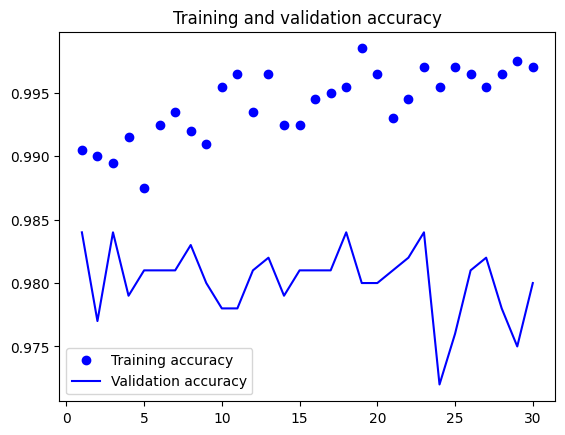

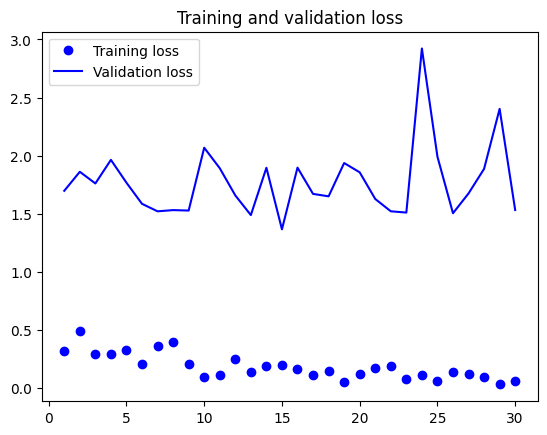

In [11]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [12]:
model = keras.models.load_model("fine_tuning.keras")

test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.9739 - loss: 1.5806
Test accuracy: 0.975
